In [1]:
from matplotlib import pyplot as plt

import pandas as pd

%load_ext autoreload
%autoreload 2

from pytorch_lightning import Trainer
import torch
from pathlib import Path


import pickle

from gnn_tracking.postprocessing.dbscanscanner import DBSCANHyperParamScannerFixed
from gnn_tracking.training.tc import TCModule
from pytorch_lightning.utilities.model_summary import ModelSummary
from gnn_tracking.analysis.plotutils import Plot

import scienceplots

plt.style.use(["science", "notebook"])
from ocpaper231.data import model_exchange_path
from gnn_tracking.utils.nomenclature import variable_manager as vm

In [57]:
from ocpaper231.data import get_dm

dm = get_dm(n_val=5, v=8)

[12:57:39] INFO: DataLoader will load 900 graphs (out of 900 available).
[12:57:39] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21999_s0.pt
[12:57:39] INFO: DataLoader will load 5 graphs (out of 1000 available).
[12:57:39] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29004_s0.pt


In [58]:
# chkpt_home = Path("/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/full_detector/lightning_logs/")
# assert chkpt_home.exists()
# chkpt_path = chkpt_home / "annoying-malkoha-from-neptune/checkpoints/persist/epoch=196-step=25200.ckpt"
# assert chkpt_path.exists()
# namestub = "annoying-malkoha-from-neptune-196"

In [59]:
chkpt_home = Path(
    "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/pixel/lightning_logs/"
)
assert chkpt_home.exists()
chkpt_path = (
    chkpt_home / "diligent-myrtle-curassow/checkpoints/epoch=299-step=270000.ckpt"
)
assert chkpt_path.exists()
namestub = "annoying-malkoha-from-neptune-299"

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [61]:
lmodel = TCModule.load_from_checkpoint(chkpt_path, map_location=device)

[12:57:42] DEBUG: Getting class GraphTCNForMLGCPipeline from module gnn_tracking.models.track_condensation_networks
[12:57:43] DEBUG: Getting class MLGraphConstruction from module gnn_tracking.models.graph_construction
[12:57:43] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[12:57:43] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses.metric_learning
[12:57:43] DEBUG: Getting class DBSCANHyperParamScanner from module gnn_tracking.postprocessing.dbscanscanner


In [62]:
ModelSummary(lmodel)

  | Name     | Type                                | Params
-----------------------------------------------------------------
0 | model    | GraphTCNForMLGCPipeline             | 1.9 M 
1 | preproc  | MLGraphConstruction                 | 333 K 
2 | loss_fct | GraphConstructionHingeEmbeddingLoss | 0     
-----------------------------------------------------------------
1.9 M     Trainable params
333 K     Non-trainable params
2.2 M     Total params
8.950     Total estimated model params size (MB)

In [63]:
# lmodel

# VS EPS

In [64]:
import numpy as np

eps = np.linspace(0.01, 1, 20)
ks = np.arange(1, 5)
trials = []
for e in eps:
    for k in ks:
        trials.append({"eps": e, "min_samples": k})

lmodel.cluster_scanner = DBSCANHyperParamScannerFixed(
    trials=trials,
)

In [65]:
ModelSummary(lmodel)

  | Name     | Type                                | Params
-----------------------------------------------------------------
0 | model    | GraphTCNForMLGCPipeline             | 1.9 M 
1 | preproc  | MLGraphConstruction                 | 333 K 
2 | loss_fct | GraphConstructionHingeEmbeddingLoss | 0     
-----------------------------------------------------------------
1.9 M     Trainable params
333 K     Non-trainable params
2.2 M     Total params
8.950     Total estimated model params size (MB)

In [66]:
trainer = Trainer(accelerator=device)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [67]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
[12:57:45] INFO: DataLoader will load 5 graphs (out of 1000 available).
[12:57:45] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29004_s0.pt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|█████████████████████████████████████████████| 5/5 [01:50<00:00,  0.05it/s]

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


Validation DataLoader 0: 100%|█████████████████████████████████████████████| 5/5 [01:50<00:00,  0.05it/s]


In [68]:
with Path(f"~/paperresults/{namestub}-vs_eps.pkl").expanduser().open("wb") as f:
    pickle.dump(lmodel.cluster_scanner, f)

In [69]:
with Path(f"~/paperresults/{namestub}-vs_eps.pkl").expanduser().open("rb") as f:
    lmodel.cluster_scanner = pickle.load(f)

0.9767878852106548 0.5831578947368421


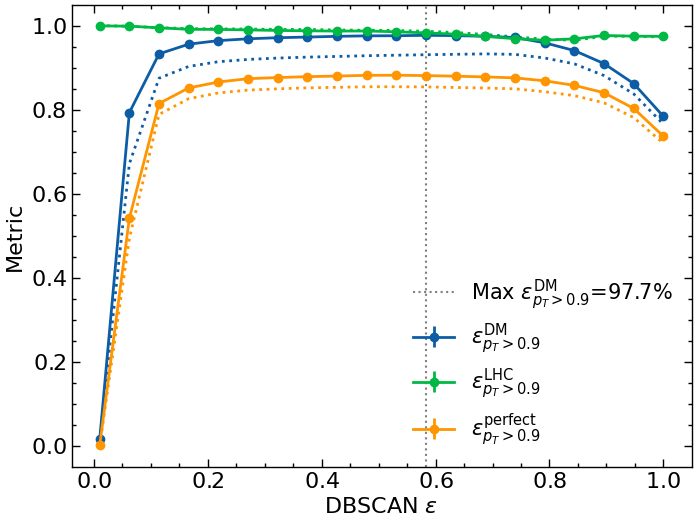

In [70]:
from gnn_tracking.analysis.efficiencies import TracksVsDBSCANPlot


tvdp = TracksVsDBSCANPlot(
    mean_df=lmodel.cluster_scanner.get_results().df_mean,
    # model=model,
    # watermark="outdated",
)
max_dm = tvdp.df["double_majority_pt0.9"].max()
max_dm_idx = tvdp.df["double_majority_pt0.9"].argmax()
max_dm_eps = tvdp.df.loc[max_dm_idx]["eps"]
print(max_dm, max_dm_eps)
secondary_k = 4
tvdp.plot_var("double_majority_pt0.9", secondary_k=secondary_k)
tvdp.plot_var("lhc_pt0.9", secondary_k=secondary_k)
tvdp.plot_var("perfect_pt0.9", secondary_k=secondary_k)
dm_label = vm["double_majority_pt0.9"].latex
tvdp.ax.axvline(
    max_dm_eps,
    color="k",
    ls=":",
    lw=1.5,
    alpha=0.5,
    label=rf"Max {dm_label}={100*max_dm:.1f}%",
)
tvdp.ax.legend(fontsize=15)
tvdp.save(Path.home() / f"paperresults/{namestub}-vs_eps.pdf")

In [71]:
tvdp.df.loc[max_dm_idx][
    [
        "fake_double_majority_pt0.9",
        "double_majority_pt0.9",
        "perfect_pt0.9",
        "lhc_pt0.9",
    ]
]

fake_double_majority_pt0.9    0.006201
double_majority_pt0.9         0.976788
perfect_pt0.9                 0.880964
lhc_pt0.9                     0.982679
Name: 44, dtype: float64

# vs pt and eta

In [72]:
h_dfs = []
c_dfs = []

In [73]:
from gnn_tracking.postprocessing.dbscanscanner import DBSCANPerformanceDetails

lmodel.cluster_scanner = DBSCANPerformanceDetails(eps=max_dm_eps, min_samples=1)

In [74]:
trainer = Trainer(accelerator="gpu")

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [75]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:186: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
[12:59:37] INFO: DataLoader will load 5 graphs (out of 1000 available).
[12:59:37] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29004_s0.pt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|█████████████████████████████████████████████| 5/5 [00:47<00:00,  0.11it/s]


In [76]:
import itertools

In [77]:
with Path(f"~/paperresults/{namestub}-details.pkl").expanduser().open("wb") as f:
    pickle.dump(lmodel.cluster_scanner, f)

In [78]:
with Path(f"~/paperresults/{namestub}-details.pkl").expanduser().open("rb") as f:
    detail_scanner = pickle.load(f)

In [79]:
h_dfs, c_dfs = detail_scanner.get_results()

In [80]:
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_vs_pt,
    tracking_metrics_vs_eta,
)
import numpy as np


pts = np.array(np.arange(0, 3, 0.3).tolist() + [5.0])
vs_pt = tracking_metrics_vs_pt(h_dfs, c_dfs, pts=pts)
etas = np.array(np.linspace(-4, 4, 20).tolist() + [4.0])
vs_eta = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)
print(len(pts), len(vs_pt), len(etas), len(vs_eta))

11 10 21 20


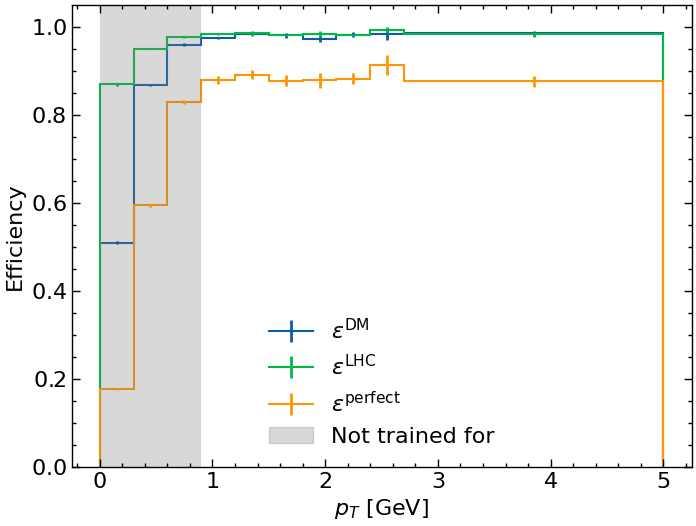

In [81]:
from gnn_tracking.analysis.efficiencies import PerformancePlot


p = PerformancePlot(df=vs_pt, xs=pts)
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.add_blocked(0, 0.9)
p.add_legend()
p.save(Path.home() / f"paperresults/{namestub}-vs_pt.pdf")

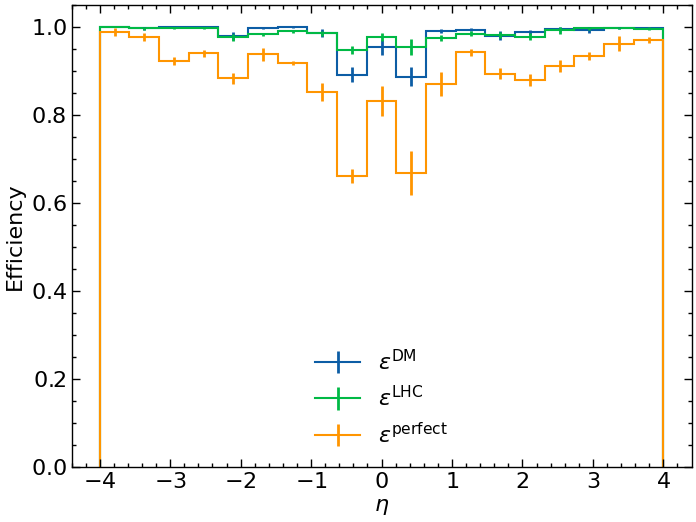

In [82]:
p = PerformancePlot(df=vs_eta, xs=etas, x_label=vm["eta"].latex)
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.ax.legend()
p.add_legend()
p.save(Path.home() / f"paperresults/{namestub}-vs_eta.pdf")

/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/analysis/efficiencies.py:132: UserWarning: The label '_ignore' of (<matplotlib.patches.StepPatch object at 0x1520e0698730>, <ErrorbarContainer object of 3 artists>) starts with '_'. It is thus excluded from the legend.
  self.ax.legend(all_handles, all_labels, **kwargs)


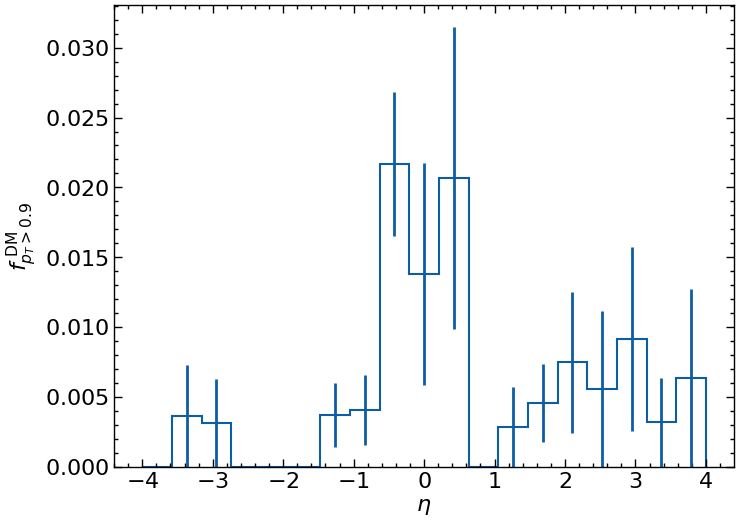

In [83]:
p = PerformancePlot(
    df=vs_eta,
    df_ul=None,
    xs=etas,
    x_label=vm["eta"].latex,
    y_label=r"$f^{\,\,\mathrm{DM}}_{p_T>0.9}$",
)
p.plot_var("fake_double_majority", "C0", label="_ignore")
p.add_legend()
p.save(Path.home() / f"paperresults/{namestub}-fake_vs_eta.pdf")

/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/analysis/efficiencies.py:132: UserWarning: The label '_' of (<matplotlib.patches.StepPatch object at 0x152138b84340>, <ErrorbarContainer object of 3 artists>) starts with '_'. It is thus excluded from the legend.
  self.ax.legend(all_handles, all_labels, **kwargs)


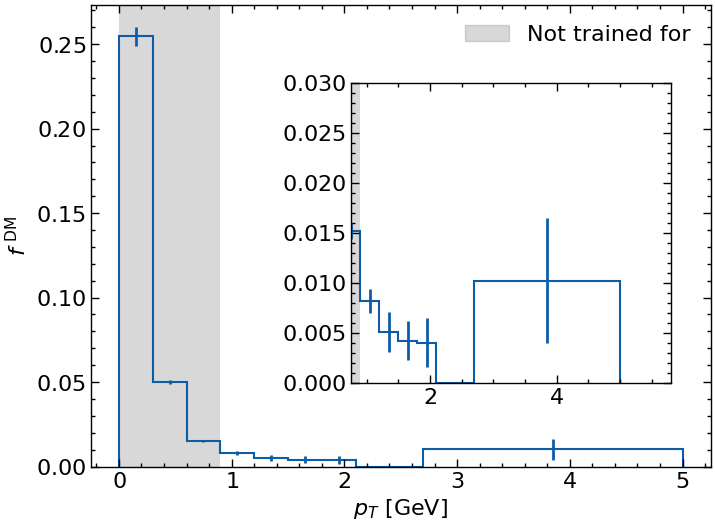

In [84]:
p = PerformancePlot(
    df=vs_pt,
    df_ul=None,
    xs=pts,
    x_label=vm["pt"].latex + " [GeV]",
    y_label=r"$f^{\,\,\mathrm{DM}}$",
)
p.add_blocked(0, 0.9)
# p.ax.set_ylim(0., 0.05)
p.plot_var("fake_double_majority", "C0", label="_")
p.add_legend()

left, bottom, width, height = [0.45, 0.25, 0.4, 0.5]
ax2 = p.ax.get_figure().add_axes([left, bottom, width, height])
p = PerformancePlot(df=vs_pt, df_ul=None, xs=pts, x_label="", y_label="", ax=ax2)
p.add_blocked(0, 0.9)
p.ax.set_xlim(0.75, 5.8)
p.ax.set_ylim(0.0, 0.03)
p.plot_var("fake_double_majority", "C0", label="_")

p.save(Path.home() / f"paperresults/{namestub}-fake_vs_pt.pdf")